In [1]:
import os # accessing directory structure

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import pickle 
#import mglearn
import time


from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from mpl_toolkits.mplot3d import Axes3D

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

In [2]:
print(os.listdir('../NLPStuff'))

['folksonomication_source-master', 'mpst_full_data.csv', '.ipynb_checkpoints', 'CATS-Main.ipynb', 'partition.json', 'MPSTGenreCorrected.csv', 'GenreCorrected.csv', 'wiki_movie_plots_deduped.csv', 'Untitled.ipynb']


In [3]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# mpst_full_data.csv has 14828 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('../NLPStuff/mpst_full_data.csv', delimiter=',')
df1.dataframeName = 'mpst_full_data.csv'
movies = pd.read_csv('../NLPStuff/wiki_movie_plots_deduped.csv', delimiter=',')
movies.dataframeName = 'wiki_movie_plots_deduped.csv'
nRow1, nCol1 = df1.shape
nRow2, nCol2 = movies.shape
print(f'There are {nRow1} rows and {nCol1} columns')
print(f'There are {nRow2} rows and {nCol2} columns')

There are 14828 rows and 6 columns
There are 34886 rows and 8 columns


In [4]:
df1.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


For the first dataset, the only relevant categories for our purposes are df1['title'], df1['plot_synopsis'] and df1['tags'].

In [5]:
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


For the second dataset, the only relevant categories for our purposes are df1['title'] and df1['plot_synopsis']. Need to generate tags ourselves.

In [6]:
# creation of the column count for aggregation
movies['Count']=1
movies[['Genre','Count']].groupby(['Genre'], as_index=False).count().shape[0]

2265

In [7]:
# creation of the column count for aggregation
df1['Count']=1
df1[['tags','Count']].groupby(['tags'], as_index=False).count().shape[0]

5604

In [8]:
# harmonization
movies['GenreCorrected'] =movies['Genre'] 
movies['GenreCorrected']=movies['GenreCorrected'].str.strip()
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' - ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' / ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('/', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' & ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(', ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('; ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bio-pic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biopic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biographical', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biodrama', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bio-drama', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biographic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(film genre\)', '')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animated','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('anime','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('children\'s','children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedey','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[not in citation given\]','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' set 4,000 years ago in the canadian arctic','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historical','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romantic','romance')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('3-d','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('3d','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('viacom 18 motion pictures','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sci-fi','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('ttriller','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('.','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('based on radio serial','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' on the early years of hitler','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sci fi','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science fiction','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' (30min)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('16 mm film','short')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[140\]','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[144\]','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' for ','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventures','adventure')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('kung fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('kung-fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial arts','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('world war ii','war')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('world war i','war')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography about montreal canadiens star|maurice richard','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bholenath movies|cinekorn entertainment','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(volleyball\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('spy film','spy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('anthology film','anthology')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography fim','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('avant-garde','avant_garde')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biker film','biker')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('buddy cop','buddy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('buddy film','buddy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedy 2-reeler','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('films','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('film','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography of pioneering american photographer eadweard muybridge','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('british-german co-production','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bruceploitation','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy-drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movies by the mob\|knkspl','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movies','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movie','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('coming of age','coming_of_age')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('coming-of-age','coming_of_age')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('drama about child soldiers','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( based).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( co-produced).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( adapted).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( about).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('musical b','musical')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animationchildren','animation|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' period','period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('drama loosely','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("yogesh dattatraya gosavi's directorial debut \[9\]",'')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("war-time","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("wartime","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("ww1","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('unknown','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("wwii","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('psychological','psycho')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('rom-coms','romance')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('true crime','crime')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|007','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('slice of life','slice_of_life')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('computer animation','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('gun fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('j-horror','horror')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(shogi|chess\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('afghan war drama','war drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|6 separate stories','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(30min\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' (road bicycle racing)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' v-cinema','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('tv miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|docudrama','\|documentary|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' in animation','|animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adaptation).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adaptated).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adapted).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( on ).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('american football','sports')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dev\|nusrat jahan','sports')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('television miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(artistic\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \|direct-to-dvd','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('history dram','history drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial art','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('psycho thriller,','psycho thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|1 girl\|3 suitors','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(road bicycle racing\)','')
filterE = movies['GenreCorrected']=="ero"
movies.loc[filterE,'GenreCorrected']="adult"
filterE = movies['GenreCorrected']=="music"
movies.loc[filterE,'GenreCorrected']="musical"
filterE = movies['GenreCorrected']=="-"
movies.loc[filterE,'GenreCorrected']=''
filterE = movies['GenreCorrected']=="comedy–drama"
movies.loc[filterE,'GenreCorrected'] = "comedy|drama"
filterE = movies['GenreCorrected']=="comedy–horror"
movies.loc[filterE,'GenreCorrected'] = "comedy|horror"
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' ','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(',','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('-','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionadventure','action|adventure')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actioncomedy','action|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actiondrama','action|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionlove','action|love')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionmasala','action|masala')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionchildren','action|children')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasychildren\|','fantasy|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasycomedy','fantasy|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasyperiod','fantasy|period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('cbctv_miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramacomedy','drama|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramacomedysocial','drama|comedy|social')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramathriller','drama|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedydrama','comedy|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramathriller','drama|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedyhorror','comedy|horror')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sciencefiction','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventurecomedy','adventure|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animationdrama','animation|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\|','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('muslim','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('thriler','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('crimethriller','crime|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantay','fantasy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionthriller','action|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedysocial','comedy|social')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martialarts','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\(children\|poker\|karuta\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('epichistory','epic|history')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('erotica','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('erotic','adult')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((\|produced\|).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('chanbara','chambara')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedythriller','comedy|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biblical','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biblical','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('colour\|yellow\|productions\|eros\|international','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|directtodvd','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('liveaction','live|action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('melodrama','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superheroes','superheroe')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('gangsterthriller','gangster|thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('heistcomedy','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('heist','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historic','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historydisaster','history|disaster')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('warcomedy','war|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('westerncomedy','western|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('ancientcostume','costume')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('computeranimation','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramatic','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familya','family')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familya','family')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramedy','drama|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramaa','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('famil\|','family')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superheroe','superhero')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biogtaphy','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('devotionalbiography','devotional|biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('docufiction','documentary|fiction')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familydrama','family|drama')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('espionage','spy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('supeheroes','superhero')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancefiction','romance|fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('horrorthriller','horror|thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('suspensethriller','suspense|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('musicaliography','musical|biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('triller','thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\(fiction\)','|fiction')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romanceaction','romance|action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancecomedy','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancehorror','romance|horror')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romcom','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('rom\|com','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('satirical','satire')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science_fictionchildren','science_fiction|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('homosexual','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sexual','adult')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('mockumentary','documentary')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('periodic','period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romanctic','romantic')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('politics','political')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('samurai','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('tv_miniseries','series')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('serial','series')

filterE = movies['GenreCorrected']=="musical–comedy"
movies.loc[filterE,'GenreCorrected'] = "musical|comedy"

filterE = movies['GenreCorrected']=="roman|porno"
movies.loc[filterE,'GenreCorrected'] = "adult"


filterE = movies['GenreCorrected']=="action—masala"
movies.loc[filterE,'GenreCorrected'] = "action|masala"


filterE = movies['GenreCorrected']=="horror–thriller"
movies.loc[filterE,'GenreCorrected'] = "horror|thriller"

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('family','children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial_arts','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('horror','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('war','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventure','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science_fiction','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('western','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('western','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('noir','black')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('spy','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superhero','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('social','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('suspense','action')


filterE = movies['GenreCorrected']=="drama|romance|adult|children"
movies.loc[filterE,'GenreCorrected'] = "drama|romance|adult"

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|–\|','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.strip(to_strip='\|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionner','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.strip()


In [9]:
# harmonization
df1['GenreCorrected'] =df1['tags'] 
df1['GenreCorrected']=df1['GenreCorrected'].str.strip()
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' - ', '|')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' / ', '|')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('/', '|')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' & ', '|')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(', ', '|')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('; ', '|')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('bio-pic', 'biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biopic', 'biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biographical', 'biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biodrama', 'biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('bio-drama', 'biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biographic', 'biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' \(film genre\)', '')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('animated','animation')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('anime','animation')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('children\'s','children')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('comedey','comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\[not in citation given\]','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' set 4,000 years ago in the canadian arctic','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('historical','history')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('romantic','romance')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('3-d','animation')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('3d','animation')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('viacom 18 motion pictures','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('sci-fi','science_fiction')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('ttriller','thriller')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('.','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('based on radio serial','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' on the early years of hitler','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('sci fi','science_fiction')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('science fiction','science_fiction')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' (30min)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('16 mm film','short')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\[140\]','drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\[144\]','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' for ','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('adventures','adventure')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('kung fu','martial_arts')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('kung-fu','martial_arts')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('martial arts','martial_arts')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('world war ii','war')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('world war i','war')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biography about montreal canadiens star|maurice richard','biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('bholenath df1|cinekorn entertainment','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' \(volleyball\)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('spy film','spy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('anthology film','anthology')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biography fim','biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('avant-garde','avant_garde')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biker film','biker')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('buddy cop','buddy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('buddy film','buddy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('comedy 2-reeler','comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('films','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('film','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biography of pioneering american photographer eadweard muybridge','biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('british-german co-production','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('bruceploitation','martial_arts')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy-drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('df1 by the mob\|knkspl','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('df1','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('movie','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('coming of age','coming_of_age')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('coming-of-age','coming_of_age')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('drama about child soldiers','drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('(( based).+)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('(( co-produced).+)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('(( adapted).+)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('(( about).+)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('musical b','musical')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('animationchildren','animation|children')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' period','period')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('drama loosely','drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace("yogesh dattatraya gosavi's directorial debut \[9\]",'')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace("war-time","war")
df1['GenreCorrected']=df1['GenreCorrected'].str.replace("wartime","war")
df1['GenreCorrected']=df1['GenreCorrected'].str.replace("ww1","war")
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('unknown','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace("wwii","war")
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('psychological','psycho')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('rom-coms','romance')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('true crime','crime')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\|007','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('slice of life','slice_of_life')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('computer animation','animation')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('gun fu','martial_arts')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('j-horror','horror')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' \(shogi|chess\)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('afghan war drama','war drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\|6 separate stories','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' \(30min\)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' (road bicycle racing)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' v-cinema','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('tv miniseries','tv_miniseries')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\|docudrama','\|documentary|drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' in animation','|animation')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('((adaptation).+)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('((adaptated).+)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('((adapted).+)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('(( on ).+)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('american football','sports')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('dev\|nusrat jahan','sports')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('television miniseries','tv_miniseries')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' \(artistic\)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' \|direct-to-dvd','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('history dram','history drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('martial art','martial_arts')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('psycho thriller,','psycho thriller')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\|1 girl\|3 suitors','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' \(road bicycle racing\)','')
filterE = df1['GenreCorrected']=="ero"
df1.loc[filterE,'GenreCorrected']="adult"
filterE = df1['GenreCorrected']=="music"
df1.loc[filterE,'GenreCorrected']="musical"
filterE = df1['GenreCorrected']=="-"
df1.loc[filterE,'GenreCorrected']=''
filterE = df1['GenreCorrected']=="comedy–drama"
df1.loc[filterE,'GenreCorrected'] = "comedy|drama"
filterE = df1['GenreCorrected']=="comedy–horror"
df1.loc[filterE,'GenreCorrected'] = "comedy|horror"
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(' ','|')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace(',','|')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('-','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('actionadventure','action|adventure')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('actioncomedy','action|comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('actiondrama','action|drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('actionlove','action|love')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('actionmasala','action|masala')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('actionchildren','action|children')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('fantasychildren\|','fantasy|children')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('fantasycomedy','fantasy|comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('fantasyperiod','fantasy|period')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('cbctv_miniseries','tv_miniseries')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('dramacomedy','drama|comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('dramacomedysocial','drama|comedy|social')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('dramathriller','drama|thriller')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('comedydrama','comedy|drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('dramathriller','drama|thriller')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('comedyhorror','comedy|horror')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('sciencefiction','science_fiction')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('adventurecomedy','adventure|comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('animationdrama','animation|drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\|\|','|')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('muslim','religious')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('thriler','thriller')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('crimethriller','crime|thriller')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('fantay','fantasy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('actionthriller','action|thriller')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('comedysocial','comedy|social')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('martialarts','martial_arts')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\|\(children\|poker\|karuta\)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('epichistory','epic|history')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('erotica','adult')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('erotic','adult')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('((\|produced\|).+)','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('chanbara','chambara')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('comedythriller','comedy|thriller')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biblical','religious')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biblical','religious')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('colour\|yellow\|productions\|eros\|international','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\|directtodvd','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('liveaction','live|action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('melodrama','drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('superheroes','superheroe')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('gangsterthriller','gangster|thriller')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('heistcomedy','comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('heist','action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('historic','history')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('historydisaster','history|disaster')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('warcomedy','war|comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('westerncomedy','western|comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('ancientcostume','costume')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('computeranimation','animation')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('dramatic','drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('familya','family')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('familya','family')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('dramedy','drama|comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('dramaa','drama')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('famil\|','family')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('superheroe','superhero')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('biogtaphy','biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('devotionalbiography','devotional|biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('docufiction','documentary|fiction')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('familydrama','family|drama')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('espionage','spy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('supeheroes','superhero')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('romancefiction','romance|fiction')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('horrorthriller','horror|thriller')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('suspensethriller','suspense|thriller')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('musicaliography','musical|biography')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('triller','thriller')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\|\(fiction\)','|fiction')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('romanceaction','romance|action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('romancecomedy','romance|comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('romancehorror','romance|horror')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('romcom','romance|comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('rom\|com','romance|comedy')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('satirical','satire')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('science_fictionchildren','science_fiction|children')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('homosexual','adult')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('sexual','adult')

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('mockumentary','documentary')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('periodic','period')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('romanctic','romantic')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('politics','political')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('samurai','martial_arts')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('tv_miniseries','series')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('serial','series')

filterE = df1['GenreCorrected']=="musical–comedy"
df1.loc[filterE,'GenreCorrected'] = "musical|comedy"

filterE = df1['GenreCorrected']=="roman|porno"
df1.loc[filterE,'GenreCorrected'] = "adult"


filterE = df1['GenreCorrected']=="action—masala"
df1.loc[filterE,'GenreCorrected'] = "action|masala"


filterE = df1['GenreCorrected']=="horror–thriller"
df1.loc[filterE,'GenreCorrected'] = "horror|thriller"

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('family','children')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('martial_arts','action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('horror','thriller')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('war','action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('adventure','action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('science_fiction','action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('western','action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('western','action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('noir','black')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('spy','action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('superhero','action')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('social','')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('suspense','action')


filterE = df1['GenreCorrected']=="drama|romance|adult|children"
df1.loc[filterE,'GenreCorrected'] = "drama|romance|adult"

df1['GenreCorrected']=df1['GenreCorrected'].str.replace('\|–\|','|')
df1['GenreCorrected']=df1['GenreCorrected'].str.strip(to_strip='\|')
df1['GenreCorrected']=df1['GenreCorrected'].str.replace('actionner','action')
df1['GenreCorrected']=df1['GenreCorrected'].str.strip()


In [10]:
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,GenreCorrected
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",1,
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",1,
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",1,
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,1,
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,1,


In [11]:
df1.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,Count,GenreCorrected
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,1,cult|thriller|gothic|murder|atmospheric
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,1,violence
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,1,romance
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,1,inspiring|romance|stupid|feelgood
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,1,cruelty|murder|drama|cult|violence|atmospheric...


In [12]:
moviesGenre = movies[['GenreCorrected','Count']].groupby(['GenreCorrected']).count()
moviesGenre.to_csv('GenreCorrected.csv',sep=',')

In [13]:
df1Genre = df1[['GenreCorrected','Count']].groupby(['GenreCorrected']).count()
df1Genre.to_csv('MPSTGenreCorrected.csv',sep=',')

In [14]:
movies[['GenreCorrected','Count']].groupby(['GenreCorrected'], as_index=False).count().shape[0]

1199

In [15]:
df1[['GenreCorrected','Count']].groupby(['GenreCorrected'], as_index=False).count().shape[0]

5586

In [16]:
movies[['GenreCorrected','Count']].groupby(['GenreCorrected'],as_index=False).count().sort_values(['Count'], ascending=False).head(10)

,GenreCorrected,Count
0,,6206
516,drama,6107
359,comedy,4411
2,action,3790
1111,thriller,2163
964,romance,954
203,animation,601
973,romance|comedy,577
447,crime,573
387,comedy|drama,560


In [17]:
df1[['GenreCorrected','Count']].groupby(['GenreCorrected'],as_index=False).count().sort_values(['Count'], ascending=False).head(10)

,GenreCorrected,Count
3303,murder,1004
4668,romance,731
5217,violence,584
4108,psychedelic,437
2706,flashback,332
5427,violence|murder,262
4389,revenge,232
1775,cult,226
781,comedy,157
4574,revenge|murder,150


In [18]:
movies['GenreSplit']=movies['GenreCorrected'].str.split('|')
movies['GenreSplit']= movies['GenreSplit'].apply(np.sort).apply(np.unique)

In [19]:
df1['GenreSplit']=df1['GenreCorrected'].str.split('|')
df1['GenreSplit']= df1['GenreSplit'].apply(np.sort).apply(np.unique)

In [20]:
genres_array = np.array([])

for i in range(0,movies.shape[0]-1):
    genres_array = np.concatenate((genres_array, movies['GenreSplit'][i] ))
    
genres_array

array(['', '', '', ..., 'comedy', 'comedy', 'romance'], dtype='<U32')

In [21]:
df1genres_array = np.array([])

for i in range(0,df1.shape[0]-1):
    df1genres_array = np.concatenate((df1genres_array, df1['GenreSplit'][i] ))
    
df1genres_array

array(['atmospheric', 'cult', 'gothic', ..., 'action', 'anti', 'murder'],
      dtype='<U32')

In [22]:
genres = pd.DataFrame({'Genre':genres_array})

In [23]:
df1genres = pd.DataFrame({'tags':df1genres_array})

In [24]:
# histogram for the genres is most welcome
genres['Count']=1
genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False).head(10)

,Genre,Count
116,drama,9487
85,comedy,7320
0,,6222
4,action,5952
426,thriller,3291
337,romance,2639
94,crime,1607
244,musical,951
16,animation,914
73,children,684


In [25]:
# histogram for the genres is most welcome
df1genres['Count']=1
df1genres[['tags','Count']].groupby(['tags'], as_index=False).sum().sort_values(['Count'], ascending=False).head(10)

,tags,Count
44,murder,5782
71,violence,4426
31,flashback,2937
59,romance,2906
21,cult,2647
58,revenge,2468
18,comedy,1930
53,psychedelic,1897
1,action,1087
2,actionful,1086


In [26]:
genres=genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False)

In [27]:
df1genres=df1genres[['tags','Count']].groupby(['tags'], as_index=False).sum().sort_values(['Count'], ascending=False)

In [28]:
genres = genres[genres['Genre']!='']
genres.head(100)

,Genre,Count
116,drama,9487
85,comedy,7320
4,action,5952
426,thriller,3291
337,romance,2639
94,crime,1607
244,musical,951
16,animation,914
73,children,684
131,fantasy,542


In [29]:
df1genres = df1genres[df1genres['tags']!='']
df1genres.head(100)

,tags,Count
44,murder,5782
71,violence,4426
31,flashback,2937
59,romance,2906
21,cult,2647
58,revenge,2468
18,comedy,1930
53,psychedelic,1897
1,action,1087
2,actionful,1086


In [30]:
TotalCountGenres=sum(genres['Count'])

In [31]:
df1TotalCountGenres=sum(df1genres['Count'])

In [32]:
genres['Frequency'] = genres['Count']/TotalCountGenres

In [33]:
df1genres['Frequency'] = df1genres['Count']/df1TotalCountGenres

In [34]:
genres['CumulativeFrequency'] = genres['Frequency'].cumsum()

In [35]:
df1genres['CumulativeFrequency'] = df1genres['Frequency'].cumsum()

In [36]:
np.array(genres[genres['CumulativeFrequency']<=.9999]['Genre'])

array(['drama', 'comedy', 'action', 'thriller', 'romance', 'crime',
       'musical', 'animation', 'children', 'fantasy', 'mystery',
       'biography', 'black', 'history', 'short', 'documentary', 'sports',
       'series', 'adult', 'political', 'costume', 'tokusatsu',
       'supernatural', 'masala', 'psycho', 'epic', 'satire', 'teen',
       'disaster', 'period', 'mythology', 'dark', 'parody', 'science',
       'religious', 'literary', 'slice_of_life', 'slasher', 'subject',
       'youth', 'propaganda', 'dance', 'devotional', 'feature',
       'folklore', 'docudrama', 'anthology', 'kaiju', 'wuxia', 'national',
       'board', 'sex', 'slapstick', 'music', 'swashbuckler',
       'exploitation', 'love', 'gangster', 'detective', 'screwball',
       'fiction', 'neoblack', 'coming_of_age', 'biker', 'road', 'girl',
       'live', 'african', 'magical', 'jidaigeki', 'sport',
       'sexploitation', 'shakespearean', 'avant_garde', 'pow', 'prison',
       'christian', 'experimental', 'monster',

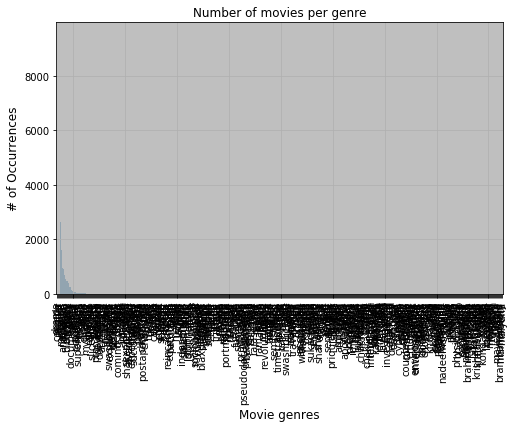

In [37]:
genres[genres['CumulativeFrequency']<=.9999][['Genre','Count']].plot(x='Genre', y='Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of movies per genre")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Movie genres', fontsize=12)
plt.show()

In [38]:
np.array(df1genres[df1genres['CumulativeFrequency']<=.9999]['tags'])

array(['murder', 'violence', 'flashback', 'romance', 'cult', 'revenge',
       'comedy', 'psychedelic', 'action', 'actionful', 'versus', 'good',
       'evil', 'drama', 'humor', 'satire', 'entertaining', 'black', 'neo',
       'sadist', 'insanity', 'tragedy', 'fantasy', 'paranormal', 'boring',
       'mystery', 'history', 'thriller', 'cruelty', 'gothic', 'dark',
       'atmospheric', 'storytelling', 'psycho', 'alternate', 'absurd',
       'realism', 'prank', 'sentimental', 'philosophical', 'avant',
       'garde', 'bleak', 'depressing', 'reality', 'twist', 'plot', 'cute',
       'stupid', 'fiction', 'intrigue', 'pornographic', 'home',
       'haunting', 'allegory', 'adult', 'thoughtprovoking', 'anti',
       'inspiring', 'comic', 'brainwashing', 'queer', 'clever',
       'claustrophobic', 'whimsical', 'feelgood', 'blaxploitation',
       'grindhouse', 'suicidal', 'magical', 'autobiography', 'christian'],
      dtype=object)

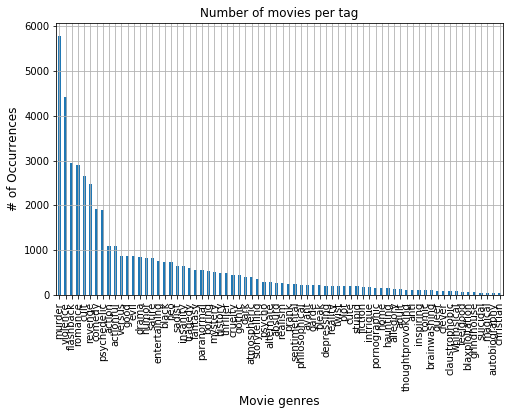

In [39]:
df1genres[df1genres['CumulativeFrequency']<=.9999][['tags','Count']].plot(x='tags', y='Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of movies per tag")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Movie genres', fontsize=12)
plt.show()

In [40]:
mainGenres=np.array(genres[genres['CumulativeFrequency']<=.9999]['Genre'])

In [41]:
df1mainGenres=np.array(df1genres[df1genres['CumulativeFrequency']<=.9999]['tags'])

In [42]:
arr1=np.array(['adult', 'romance', 'drama','and'])
arr1[np.in1d(arr1,mainGenres)] # genres not in the mainGenres array will be deleted

array(['adult', 'romance', 'drama', 'and'], dtype='<U7')

In [43]:
movies['GenreSplit'][1:12].apply(lambda x: x[np.in1d(x,mainGenres)])

1                         []
2                         []
3                         []
4                         []
5                         []
6                   [action]
7                   [comedy]
8                         []
9                         []
10                   [short]
11    [action, crime, short]
Name: GenreSplit, dtype: object

In [44]:
df1['GenreSplit'][1:12].apply(lambda x: x[np.in1d(x,df1mainGenres)])

1                                            [violence]
2                                             [romance]
3                [feelgood, inspiring, romance, stupid]
4     [action, atmospheric, cruelty, cult, drama, mu...
5                           [flashback, queer, romance]
6     [cruelty, cult, gothic, revenge, sadist, viole...
7       [action, actionful, flashback, murder, mystery]
8                                            [violence]
9     [black, flashback, murder, neo, revenge, viole...
10                                        [cult, prank]
11                [cult, murder, psychedelic, violence]
Name: GenreSplit, dtype: object

In [45]:
movies['GenreSplitMain'] = movies['GenreSplit'].apply(lambda x: x[np.in1d(x,mainGenres)])

In [70]:
df1['GenreSplitMain'] = df1['GenreSplit'].apply(lambda x: x[np.in1d(x,df1mainGenres)])

In [46]:
movies[['GenreSplitMain','GenreSplit','Genre']][200:220]

,GenreSplitMain,GenreSplit,Genre
200,[drama],[drama],drama
201,[drama],[drama],drama
202,[comedy],[comedy],comedy
203,[drama],[drama],drama
204,[comedy],[comedy],comedy
205,"[comedy, drama]","[comedy, drama]",comedy drama
206,[mystery],[mystery],mystery
207,[drama],[drama],drama
208,[drama],[drama],drama
209,"[comedy, drama]","[comedy, drama]",comedy drama


In [71]:
df1[['GenreSplitMain','GenreSplit','tags']][200:220]

,GenreSplitMain,GenreSplit,tags
200,"[allegory, cult, fantasy, flashback, psychedel...","[allegory, cult, fantasy, flashback, psychedel...","fantasy, allegory, cult, flashback, psychedeli..."
201,"[boring, cult, drama, fantasy, flashback, insa...","[boring, cult, drama, fantasy, flashback, insa...","fantasy, psychological, murder, boring, cult, ..."
202,"[black, flashback, murder, neo]","[black, flashback, murder, neo]","neo noir, murder, flashback"
203,"[cruelty, cult, violence]","[cruelty, cult, violence]","cult, cruelty, violence"
204,[psychedelic],[psychedelic],psychedelic
205,[cult],[cult],cult
206,"[evil, good, paranormal, versus]","[evil, good, paranormal, versus]","good versus evil, paranormal"
207,[murder],[murder],murder
208,"[cute, entertaining, psychedelic, romance]","[cute, entertaining, psychedelic, romance]","psychedelic, cute, entertaining, romantic"
209,"[actionful, black, flashback, murder, neo, sad...","[actionful, black, flashback, murder, neo, sad...","neo noir, murder, violence, flashback, suspens..."


In [47]:
# function for cleaning the plots of the movies
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    #text = re.sub('\W', ' ', text)
    #text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [48]:
list(movies['Plot'][10:12].apply(clean_text))

['the rarebit fiend gorges on welsh rarebit at a restaurant. when he leaves, he begins to get dizzy as he starts to hallucinate. he desperately tries to hang onto a lamppost as the world spins all around him. a man helps him get home. he falls into bed and begins having more hallucinatory dreams. during a dream sequence, the furniture begins moving around the room. imps emerge from a floating welsh rarebit container and begin poking his head as he sleeps. his bed then begins dancing and spinning wildly around the room before flying out the window with the fiend in it. the bed floats across the city as the fiend floats up and off the bed. he hangs off the back and eventually gets caught on a weathervane atop a steeple. his bedclothes tear and he falls from the sky, crashing through his bedroom ceiling. the fiend awakens from the dream after falling out of his bed.',
 'the film features a train traveling through the rockies and a hold up created by two thugs placing logs on the line. the

In [72]:
list(df1['plot_synopsis'][10:12].apply(clean_text))

['the action takes place in the years 1958-1959 in sweden. troubled 12 year-old ingemar (anton glanzelius) gets into all sorts of trouble, which bothers his mother (anki lidén); ingemar does not know that his mother is in fact terminally ill. when he and his older brother become too much for her, they are split up and sent to live with relatives. ingemar ends up with his maternal uncle gunnar (tomas von brömssen) and his wife ulla (kicki rundgren) in a small rural town in småland. gunnar and ingemar bond over povel ramel  recording of "far, jag kan inte få upp min kokosnöt".\nin the town he encounters a variety of characters. saga (melinda kinnaman), an assertive tomboy his own age, likes him, and shows it by beating him in a boxing match. among the more eccentric residents is fransson (magnus rask), a man who continually fixes the roof of his house, and mr. arvidsson (didrik gustavsson), an old man living downstairs who gets ingemar to read to him from a lingerie catalog.\nlater, inge

In [49]:
list(movies['Plot'][10:12])

['The Rarebit Fiend gorges on Welsh rarebit at a restaurant. When he leaves, he begins to get dizzy as he starts to hallucinate. He desperately tries to hang onto a lamppost as the world spins all around him. A man helps him get home. He falls into bed and begins having more hallucinatory dreams. During a dream sequence, the furniture begins moving around the room. Imps emerge from a floating Welsh rarebit container and begin poking his head as he sleeps. His bed then begins dancing and spinning wildly around the room before flying out the window with the Fiend in it. The bed floats across the city as the Fiend floats up and off the bed. He hangs off the back and eventually gets caught on a weathervane atop a steeple. His bedclothes tear and he falls from the sky, crashing through his bedroom ceiling. The Fiend awakens from the dream after falling out of his bed.',
 'The film features a train traveling through the Rockies and a hold up created by two thugs placing logs on the line. The

In [50]:
movies['PlotClean'] = movies['Plot'].apply(clean_text)

In [73]:
df1['PlotClean'] = df1['plot_synopsis'].apply(clean_text)

In [51]:
movies[['Plot','PlotClean','GenreSplitMain']][6:12]

,Plot,PlotClean,GenreSplitMain
6,The film opens with two bandits breaking into ...,the film opens with two bandits breaking into ...,[action]
7,The film is about a family who move to the sub...,the film is about a family who move to the sub...,[comedy]
8,The opening scene shows the interior of the ro...,the opening scene shows the interior of the ro...,[]
9,Scenes are introduced using lines of the poem....,scenes are introduced using lines of the poem....,[]
10,The Rarebit Fiend gorges on Welsh rarebit at a...,the rarebit fiend gorges on welsh rarebit at a...,[short]
11,The film features a train traveling through th...,the film features a train traveling through th...,"[action, crime, short]"


In [52]:
len(movies['GenreSplitMain'][0])

0

In [53]:
movies['GenreSplitMain'][0:5].apply(len)

0    0
1    0
2    0
3    0
4    0
Name: GenreSplitMain, dtype: int64

In [74]:
df1['GenreSplitMain'][0:5].apply(len)

0     5
1     1
2     1
3     4
4    10
Name: GenreSplitMain, dtype: int64

In [54]:
movies['MainGenresCount'] = movies['GenreSplitMain'].apply(len)

In [75]:
df1['MainGenresCount'] = df1['GenreSplitMain'].apply(len)

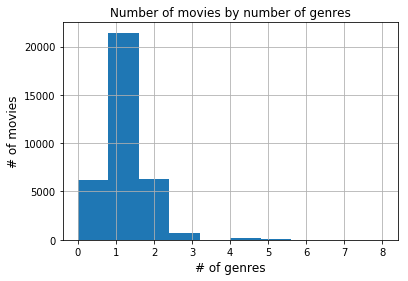

In [55]:
movies['MainGenresCount'].hist()

plt.title("Number of movies by number of genres")
plt.ylabel('# of movies', fontsize=12)
plt.xlabel('# of genres', fontsize=12)
plt.show()

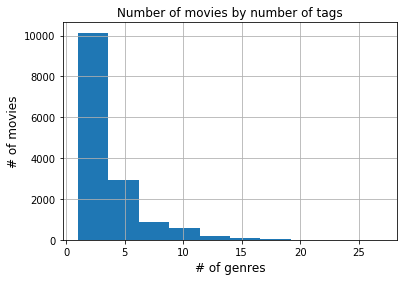

In [77]:
df1['MainGenresCount'].hist()

plt.title("Number of movies by number of tags")
plt.ylabel('# of movies', fontsize=12)
plt.xlabel('# of genres', fontsize=12)
plt.show()

In [56]:
# Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

In [57]:
movies.GenreSplitMain[6:15].apply(lambda x: '-'.join(x)).str.split(pat='-',n=5,expand=True)

,0,1,2
6,action,None,None
7,comedy,None,None
8,,None,None
9,,None,None
10,short,None,None
11,action,crime,short
12,short,None,None
13,biography,None,None
14,comedy,None,None


In [78]:
df1.GenreSplitMain[6:15].apply(lambda x: '-'.join(x)).str.split(pat='-',n=5,expand=True)

,0,1,2,3,4,5
6,cruelty,cult,gothic,revenge,sadist,violence
7,action,actionful,flashback,murder,mystery,None
8,violence,None,None,None,None,None
9,black,flashback,murder,neo,revenge,violence
10,cult,prank,None,None,None,None
11,cult,murder,psychedelic,violence,None,None
12,drama,murder,tragedy,None,None,None
13,murder,None,None,None,None,None
14,autobiography,flashback,home,None,None,None


In [58]:
movies.GenreSplitMain[6:15].apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')

,action,biography,comedy,crime,short
6,1,0,0,0,0
7,0,0,1,0,0
8,0,0,0,0,0
9,0,0,0,0,0
10,0,0,0,0,1
11,1,0,0,1,1
12,0,0,0,0,1
13,0,1,0,0,0
14,0,0,1,0,0


In [79]:
df1.GenreSplitMain[6:15].apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')

,action,actionful,autobiography,black,cruelty,cult,drama,flashback,gothic,home,murder,mystery,neo,prank,psychedelic,revenge,sadist,tragedy,violence
6,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,1
7,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1
10,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
11,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
12,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
13,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
14,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0


In [59]:
movies.GenreSplitMain[6:15]

6                   [action]
7                   [comedy]
8                         []
9                         []
10                   [short]
11    [action, crime, short]
12                   [short]
13               [biography]
14                  [comedy]
Name: GenreSplitMain, dtype: object

In [80]:
df1.GenreSplitMain[6:15]

6     [cruelty, cult, gothic, revenge, sadist, viole...
7       [action, actionful, flashback, murder, mystery]
8                                            [violence]
9     [black, flashback, murder, neo, revenge, viole...
10                                        [cult, prank]
11                [cult, murder, psychedelic, violence]
12                             [drama, murder, tragedy]
13                                             [murder]
14                     [autobiography, flashback, home]
Name: GenreSplitMain, dtype: object

In [60]:
# the dummy classes
movies = pd.concat([movies, movies.GenreSplitMain.apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')], axis=1)

In [81]:
# the dummy classes
df1 = pd.concat([df1, df1.GenreSplitMain.apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')], axis=1)

In [61]:
# the train and the test data set will be build when there is at least one genre for a movie
MoviesTrain, MoviesTest = train_test_split(movies[movies.GenreCorrected!=''], random_state=42, test_size=0.30, shuffle=True)

In [83]:
# the train and the test data set will be build when there is at least one genre for a movie
df1MoviesTrain, df1MoviesTest = train_test_split(df1[df1.GenreCorrected!=''], random_state=42, test_size=0.30, shuffle=True)

In [62]:
# definition the algorithm for feature extraction
tfidf = TfidfVectorizer(stop_words ='english', smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')

In [63]:
# building the features
x_train = tfidf.fit_transform(MoviesTrain.PlotClean) 
x_test  = tfidf.transform(MoviesTest.PlotClean)
### for test data, the feature extraction will be done through the function transform()
### to make sure there is no features dimensionality mismatch

In [84]:
x_train2 = tfidf.fit_transform(df1MoviesTrain.PlotClean) 
x_test2 = tfidf.transform(df1MoviesTest.PlotClean)

In [64]:
tfidf.inverse_transform(x_train[0].toarray())

[array(['1930s', '1937', 'abilities', 'able', 'accept', 'accepts',
        'acquaintance', 'actively', 'adversely', 'affects', 'aggressive',
        'agrees', 'aide', 'allow', 'amidst', 'apartment', 'arena', 'army',
        'arouses', 'arrives', 'artist', 'artists', 'arts', 'attempts',
        'away', 'bag', 'bandit', 'bandits', 'barely', 'barrage', 'battle',
        'beaten', 'beating', 'beats', 'blows', 'bruce', 'brutal',
        'challenge', 'challenges', 'chance', 'chaos', 'cheered', 'child',
        'chinese', 'ching', 'chow', 'chuen', 'chun', 'claimed', 'closed',
        'coal', 'colleagues', 'collect', 'colonel', 'come', 'compete',
        'competitions', 'consents', 'conserve', 'contain', 'cotton',
        'crowd', 'days', 'declines', 'decrepit', 'defeat', 'defeats',
        'defends', 'defense', 'demands', 'desperate', 'despite', 'direct',
        'disciples', 'discussing', 'displays', 'does', 'door', 'earlier',
        'earn', 'effective', 'embarrassing', 'energy', 'enhanced'

In [85]:
tfidf.inverse_transform(x_train2[0].toarray())

[array(['abandons', 'accident', 'adding', 'address', 'ago', 'ana', 'area',
        'arrived', 'asks', 'backpack', 'beer', 'bom', 'boy', 'boys',
        'brazil', 'brother', 'brothers', 'bus', 'buses', 'calls',
        'carried', 'case', 'catch', 'central', 'come', 'containing',
        'corrupt', 'couple', 'current', 'customers', 'deciding',
        'departure', 'destitution', 'died', 'dinner', 'disappeared',
        'does', 'dora', 'drawer', 'drink', 'drinking', 'driver', 'drunken',
        'embittered', 'encourages', 'ends', 'evangelical', 'explains',
        'expressing', 'family', 'father', 'feel', 'follows', 'forgetting',
        'friend', 'friendly', 'geraldo', 'gets', 'gone', 'grows', 'guilty',
        'half', 'hangs', 'homeless', 'hopes', 'house', 'illiterate',
        'impatient', 'initially', 'insists', 'introduced', 'introducing',
        'invites', 'irene', 'isaías', 'janeiro', 'jesus', 'josué', 'just',
        'killed', 'kind', 'know', 'late', 'later', 'learns', 'leave',
 

In [65]:
# building the classes
y_train = MoviesTrain[MoviesTrain.columns[14:]]
y_test = MoviesTest[MoviesTest.columns[14:]]

In [87]:
# building the classes
y_train2 = df1MoviesTrain[df1MoviesTrain.columns[14:]]
y_test2 = df1MoviesTest[df1MoviesTest.columns[14:]]

In [66]:
multinomialNB=OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

In [67]:
accuracy_multinomialNB=pd.DataFrame(columns=['Genre', 'accuracy_multinomialNB'])
accuracy_multinomialNB.head()

,Genre,accuracy_multinomialNB


In [68]:
i = 0
for genre in mainGenres:
    multinomialNB.fit(x_train, y_train[genre])
    prediction = multinomialNB.predict(x_test)
    accuracy_multinomialNB.loc[i,'Genre'] = genre
    accuracy_multinomialNB.loc[i,'accuracy_multinomialNB'] = accuracy_score(y_test[genre], prediction)
    i=i+1
    

    
accuracy_multinomialNB

/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/s

/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/s

,Genre,accuracy_multinomialNB
0,drama,0.673756
1,comedy,0.733147
2,action,0.826592
3,thriller,0.884589
4,romance,0.843096
5,crime,0.911088
6,musical,0.937587
7,animation,0.973849
8,children,0.957578
9,fantasy,0.974314


In [69]:
multinomialNB.predict()

TypeError: predict() missing 1 required positional argument: 'X'